In [58]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [59]:
apple = Stocker("AAPL")

[*********************100%***********************]  1 of 1 completed
AAPL Stocker Initialized. Data covers 1980-12-12 00:00:00 to 2020-04-08 00:00:00.


In [60]:
apple.stock

,Date,Open,High,Low,Close,Adj Close,Volume,ds,Adj. Close,Adj. Open,y,Daily Change
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,1980-12-12,0.513393,0.513393,0.513393,0.000000
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,1980-12-15,0.486607,0.488839,0.486607,-0.002232
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,1980-12-16,0.450893,0.453125,0.450893,-0.002232
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,1980-12-17,0.462054,0.462054,0.462054,0.000000
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,1980-12-18,0.475446,0.475446,0.475446,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
9908,2020-04-01,246.500000,248.720001,239.130005,240.910004,240.910004,44054600,2020-04-01,240.910004,246.500000,240.910004,-5.589996
9909,2020-04-02,240.339996,245.149994,236.899994,244.929993,244.929993,41483500,2020-04-02,244.929993,240.339996,244.929993,4.589996
9910,2020-04-03,242.800003,245.699997,238.970001,241.410004,241.410004,32470000,2020-04-03,241.410004,242.800003,241.410004,-1.389999
9911,2020-04-06,250.899994,263.109985,249.380005,262.470001,262.470001,50289700,2020-04-06,262.470001,250.899994,262.470001,11.570007


In [70]:
df = apple.stock[["Date", "Open",	"High",	"Low",	"Close",	"Adj Close",	"Volume"]
 ]


In [71]:
df = df[(df.Date >= "2017-01-01") & (df.Date <= "2020-01-01")]

In [72]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
9092,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.691154,28781900
9093,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.567276,21118100
9094,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.129562,22193600
9095,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.368469,31751900
9096,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.397697,33561900
...,...,...,...,...,...,...,...
9841,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700
9842,2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300
9843,2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500
9844,2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600


In [73]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.000732
1,0.000000
2,0.003322
3,0.010640
4,0.016720


In [74]:
test_size = 30
simulation_size = 10
df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((754, 7), (724, 1), (30, 1))

In [75]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [76]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [77]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [78]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.5, cost=0.00288]




train loop:   0%|          | 1/300 [00:01<06:04,  1.22s/it, acc=96.5, cost=0.00288]




train loop:   0%|          | 1/300 [00:02<06:04,  1.22s/it, acc=93.3, cost=0.0158] 




train loop:   1%|          | 2/300 [00:02<05:56,  1.19s/it, acc=93.3, cost=0.0158]




train loop:   1%|          | 2/300 [00:03<05:56,  1.19s/it, acc=93.9, cost=0.0146]




train loop:   1%|          | 3/300 [00:03<05:52,  1.19s/it, acc=93.9, cost=0.0146]




train loop:   1%|          | 3/300 [00:04<05:52,  1.19s/it, acc=96.8, cost=0.00511]




train loop:   1%|▏         | 4/300 [00:04<05:59,  1.21s/it, acc=96.8, cost=0.00511]




train loop:   1%|▏         | 4/300 [00:05<05:59,  1.21s/it, acc=98, cost=0.000911] 




train loop:   2%|▏         | 5/300 [00:05<05:56,  1.21s/it, acc=98, cost=0.000911]




train loop:   2%|▏         | 5/300 [00:07<05:56,  1.21s/it, acc=98.6, c

simulation 2







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.3, cost=0.00345]




train loop:   0%|          | 1/300 [00:01<06:07,  1.23s/it, acc=96.3, cost=0.00345]




train loop:   0%|          | 1/300 [00:02<06:07,  1.23s/it, acc=94.3, cost=0.00978]




train loop:   1%|          | 2/300 [00:02<06:11,  1.25s/it, acc=94.3, cost=0.00978]




train loop:   1%|          | 2/300 [00:03<06:11,  1.25s/it, acc=95.2, cost=0.0086] 




train loop:   1%|          | 3/300 [00:03<06:07,  1.24s/it, acc=95.2, cost=0.0086]




train loop:   1%|          | 3/300 [00:04<06:07,  1.24s/it, acc=97.2, cost=0.0029]




train loop:   1%|▏         | 4/300 [00:04<06:07,  1.24s/it, acc=97.2, cost=0.0029]




train loop:   1%|▏         | 4/300 [00:06<06:07,  1.24s/it, acc=97.7, cost=0.00121]




train loop:   2%|▏         | 5/300 [00:06<06:00,  1.22s/it, acc=97.7, cost=0.00121]




train loop:   2%|▏         | 5/300 [00:07<06:00,  1.22s/it, acc=98.1, 

simulation 3







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.6, cost=0.00293]




train loop:   0%|          | 1/300 [00:01<05:58,  1.20s/it, acc=96.6, cost=0.00293]




train loop:   0%|          | 1/300 [00:02<05:58,  1.20s/it, acc=94.4, cost=0.01]   




train loop:   1%|          | 2/300 [00:02<05:45,  1.16s/it, acc=94.4, cost=0.01]




train loop:   1%|          | 2/300 [00:03<05:45,  1.16s/it, acc=93.7, cost=0.0147]




train loop:   1%|          | 3/300 [00:03<05:35,  1.13s/it, acc=93.7, cost=0.0147]




train loop:   1%|          | 3/300 [00:04<05:35,  1.13s/it, acc=95.9, cost=0.00716]




train loop:   1%|▏         | 4/300 [00:04<05:32,  1.12s/it, acc=95.9, cost=0.00716]




train loop:   1%|▏         | 4/300 [00:05<05:32,  1.12s/it, acc=97.4, cost=0.002]  




train loop:   2%|▏         | 5/300 [00:05<05:29,  1.12s/it, acc=97.4, cost=0.002]




train loop:   2%|▏         | 5/300 [00:06<05:29,  1.12s/it, acc=98, cost=0

simulation 4







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.7, cost=0.00273]




train loop:   0%|          | 1/300 [00:01<05:59,  1.20s/it, acc=96.7, cost=0.00273]




train loop:   0%|          | 1/300 [00:02<05:59,  1.20s/it, acc=94.3, cost=0.0103] 




train loop:   1%|          | 2/300 [00:02<05:48,  1.17s/it, acc=94.3, cost=0.0103]




train loop:   1%|          | 2/300 [00:03<05:48,  1.17s/it, acc=94.4, cost=0.0122]




train loop:   1%|          | 3/300 [00:03<05:40,  1.15s/it, acc=94.4, cost=0.0122]




train loop:   1%|          | 3/300 [00:04<05:40,  1.15s/it, acc=96.3, cost=0.0059]




train loop:   1%|▏         | 4/300 [00:04<05:32,  1.12s/it, acc=96.3, cost=0.0059]




train loop:   1%|▏         | 4/300 [00:05<05:32,  1.12s/it, acc=97.6, cost=0.00178]




train loop:   2%|▏         | 5/300 [00:05<05:29,  1.12s/it, acc=97.6, cost=0.00178]




train loop:   2%|▏         | 5/300 [00:06<05:29,  1.12s/it, acc=98.1, co

simulation 5







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.8, cost=0.00258]




train loop:   0%|          | 1/300 [00:01<06:03,  1.22s/it, acc=96.8, cost=0.00258]




train loop:   0%|          | 1/300 [00:02<06:03,  1.22s/it, acc=93.4, cost=0.0173] 




train loop:   1%|          | 2/300 [00:02<05:49,  1.17s/it, acc=93.4, cost=0.0173]




train loop:   1%|          | 2/300 [00:03<05:49,  1.17s/it, acc=94.1, cost=0.0128]




train loop:   1%|          | 3/300 [00:03<05:42,  1.15s/it, acc=94.1, cost=0.0128]




train loop:   1%|          | 3/300 [00:04<05:42,  1.15s/it, acc=96.3, cost=0.0062]




train loop:   1%|▏         | 4/300 [00:04<05:36,  1.14s/it, acc=96.3, cost=0.0062]




train loop:   1%|▏         | 4/300 [00:05<05:36,  1.14s/it, acc=97.9, cost=0.000978]




train loop:   2%|▏         | 5/300 [00:05<05:29,  1.12s/it, acc=97.9, cost=0.000978]




train loop:   2%|▏         | 5/300 [00:06<05:29,  1.12s/it, acc=97.8, 

simulation 6







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.4, cost=0.00305]




train loop:   0%|          | 1/300 [00:01<05:31,  1.11s/it, acc=96.4, cost=0.00305]




train loop:   0%|          | 1/300 [00:02<05:31,  1.11s/it, acc=94.3, cost=0.0104] 




train loop:   1%|          | 2/300 [00:02<05:24,  1.09s/it, acc=94.3, cost=0.0104]




train loop:   1%|          | 2/300 [00:03<05:24,  1.09s/it, acc=93.5, cost=0.0156]




train loop:   1%|          | 3/300 [00:03<05:24,  1.09s/it, acc=93.5, cost=0.0156]




train loop:   1%|          | 3/300 [00:04<05:24,  1.09s/it, acc=95.6, cost=0.0097]




train loop:   1%|▏         | 4/300 [00:04<05:20,  1.08s/it, acc=95.6, cost=0.0097]




train loop:   1%|▏         | 4/300 [00:05<05:20,  1.08s/it, acc=97.3, cost=0.00219]




train loop:   2%|▏         | 5/300 [00:05<05:17,  1.08s/it, acc=97.3, cost=0.00219]




train loop:   2%|▏         | 5/300 [00:06<05:17,  1.08s/it, acc=97.8, co

simulation 7







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.5, cost=0.00299]




train loop:   0%|          | 1/300 [00:01<05:47,  1.16s/it, acc=96.5, cost=0.00299]




train loop:   0%|          | 1/300 [00:02<05:47,  1.16s/it, acc=93.9, cost=0.0124] 




train loop:   1%|          | 2/300 [00:02<05:39,  1.14s/it, acc=93.9, cost=0.0124]




train loop:   1%|          | 2/300 [00:03<05:39,  1.14s/it, acc=94.5, cost=0.0112]




train loop:   1%|          | 3/300 [00:03<05:36,  1.13s/it, acc=94.5, cost=0.0112]




train loop:   1%|          | 3/300 [00:04<05:36,  1.13s/it, acc=96.6, cost=0.00441]




train loop:   1%|▏         | 4/300 [00:04<05:30,  1.12s/it, acc=96.6, cost=0.00441]




train loop:   1%|▏         | 4/300 [00:05<05:30,  1.12s/it, acc=97.9, cost=0.0012] 




train loop:   2%|▏         | 5/300 [00:05<05:24,  1.10s/it, acc=97.9, cost=0.0012]




train loop:   2%|▏         | 5/300 [00:06<05:24,  1.10s/it, acc=98.2, c

simulation 8







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.6, cost=0.00287]




train loop:   0%|          | 1/300 [00:01<05:47,  1.16s/it, acc=96.6, cost=0.00287]




train loop:   0%|          | 1/300 [00:02<05:47,  1.16s/it, acc=93.5, cost=0.0167] 




train loop:   1%|          | 2/300 [00:02<05:36,  1.13s/it, acc=93.5, cost=0.0167]




train loop:   1%|          | 2/300 [00:03<05:36,  1.13s/it, acc=94.1, cost=0.0128]




train loop:   1%|          | 3/300 [00:03<05:30,  1.11s/it, acc=94.1, cost=0.0128]




train loop:   1%|          | 3/300 [00:04<05:30,  1.11s/it, acc=96.8, cost=0.00492]




train loop:   1%|▏         | 4/300 [00:04<05:27,  1.11s/it, acc=96.8, cost=0.00492]




train loop:   1%|▏         | 4/300 [00:05<05:27,  1.11s/it, acc=98.1, cost=0.000721]




train loop:   2%|▏         | 5/300 [00:05<05:27,  1.11s/it, acc=98.1, cost=0.000721]




train loop:   2%|▏         | 5/300 [00:06<05:27,  1.11s/it, acc=98.2

simulation 9







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.3, cost=0.00327]




train loop:   0%|          | 1/300 [00:01<05:52,  1.18s/it, acc=96.3, cost=0.00327]




train loop:   0%|          | 1/300 [00:02<05:52,  1.18s/it, acc=93.4, cost=0.0155] 




train loop:   1%|          | 2/300 [00:02<05:42,  1.15s/it, acc=93.4, cost=0.0155]




train loop:   1%|          | 2/300 [00:03<05:42,  1.15s/it, acc=94.3, cost=0.0128]




train loop:   1%|          | 3/300 [00:03<05:38,  1.14s/it, acc=94.3, cost=0.0128]




train loop:   1%|          | 3/300 [00:04<05:38,  1.14s/it, acc=96.8, cost=0.00537]




train loop:   1%|▏         | 4/300 [00:04<05:30,  1.12s/it, acc=96.8, cost=0.00537]




train loop:   1%|▏         | 4/300 [00:05<05:30,  1.12s/it, acc=97.8, cost=0.0012] 




train loop:   2%|▏         | 5/300 [00:05<05:24,  1.10s/it, acc=97.8, cost=0.0012]




train loop:   2%|▏         | 5/300 [00:06<05:24,  1.10s/it, acc=98.6, c

simulation 10







train loop:   0%|          | 0/300 [00:00<?, ?it/s]




train loop:   0%|          | 0/300 [00:01<?, ?it/s, acc=96.3, cost=0.00329]




train loop:   0%|          | 1/300 [00:01<06:09,  1.24s/it, acc=96.3, cost=0.00329]




train loop:   0%|          | 1/300 [00:02<06:09,  1.24s/it, acc=91.4, cost=0.096]  




train loop:   1%|          | 2/300 [00:02<05:59,  1.21s/it, acc=91.4, cost=0.096]




train loop:   1%|          | 2/300 [00:03<05:59,  1.21s/it, acc=92.5, cost=0.0232]




train loop:   1%|          | 3/300 [00:03<05:50,  1.18s/it, acc=92.5, cost=0.0232]




train loop:   1%|          | 3/300 [00:04<05:50,  1.18s/it, acc=96.3, cost=0.00475]




train loop:   1%|▏         | 4/300 [00:04<05:42,  1.16s/it, acc=96.3, cost=0.00475]




train loop:   1%|▏         | 4/300 [00:05<05:42,  1.16s/it, acc=97.8, cost=0.00102]




train loop:   2%|▏         | 5/300 [00:05<05:37,  1.15s/it, acc=97.8, cost=0.00102]




train loop:   2%|▏         | 5/300 [00:06<05:37,  1.15s/it, acc=98.1, c

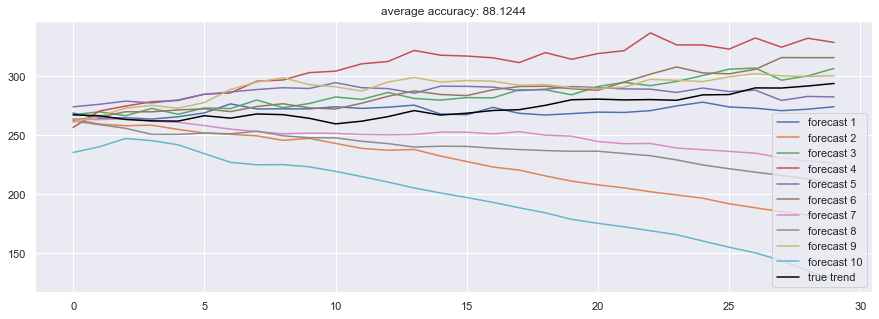

In [79]:

accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()
